In [ ]:
# implementing https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [52]:
# build the dataset

block_size = 3  # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]  # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [53]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [100]:
# build the dataset
block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):  

    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))  # training 80%
n2 = int(0.9 * len(words))  # dev/validation 10%, test is remaining 10%

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [12]:
C = torch.randn((27, 2))

In [13]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [24]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)  # doesn't generalize, assumes block_size = 3
torch.cat(torch.unbind(emb, 1), 1)  # generalizes, but concat creates new tensors in memory
emb.view(32, 6).shape  # most efficient approach

torch.Size([32, 6])

In [25]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [26]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [27]:
h

tensor([[-0.3391,  0.3140, -0.2894,  ..., -0.0353, -0.7969,  0.9768],
        [ 0.8806, -0.8966, -0.4614,  ...,  0.6810, -0.9867,  0.5710],
        [ 0.9997, -0.9682,  0.3458,  ...,  0.3540, -0.8931, -0.9981],
        ...,
        [-0.9828, -0.2334,  0.9879,  ...,  0.9744, -0.8780,  0.9997],
        [ 0.7882, -0.3495, -0.8245,  ...,  0.2287, -0.9976,  0.5410],
        [-0.8227,  0.9270, -0.2212,  ...,  0.9935, -0.9984,  0.8703]])

In [28]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [29]:
logits = h @ W2 + b2

In [30]:
logits.shape

torch.Size([32, 27])

In [39]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()

# above is equivalent to:
loss = F.cross_entropy(logits, Y)


In [111]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [146]:
# Rewriting for clarity
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [147]:
sum(p.nelement() for p in parameters)

11897

In [148]:
for p in parameters:
    p.requires_grad = True

In [149]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [150]:
lri = []
lossi = []
stepi = []

In [151]:
for i in range(200000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (64,))
    
    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
#     lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
#     lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
        
print(loss.item())

2.0976312160491943


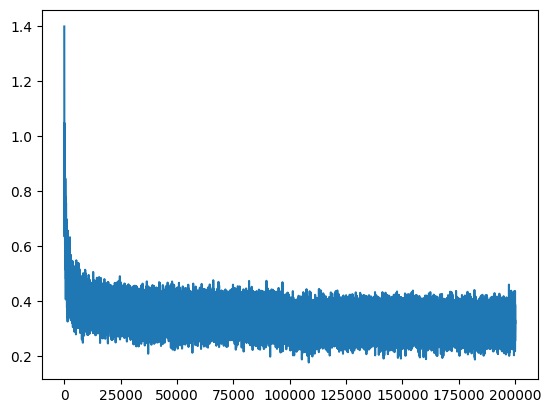

In [152]:
plt.plot(stepi, lossi)

In [153]:
# Train Loss
emb = C[Xtr]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1150, grad_fn=<NllLossBackward0>)

In [154]:
# Validation Loss
emb = C[Xdev]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1517, grad_fn=<NllLossBackward0>)

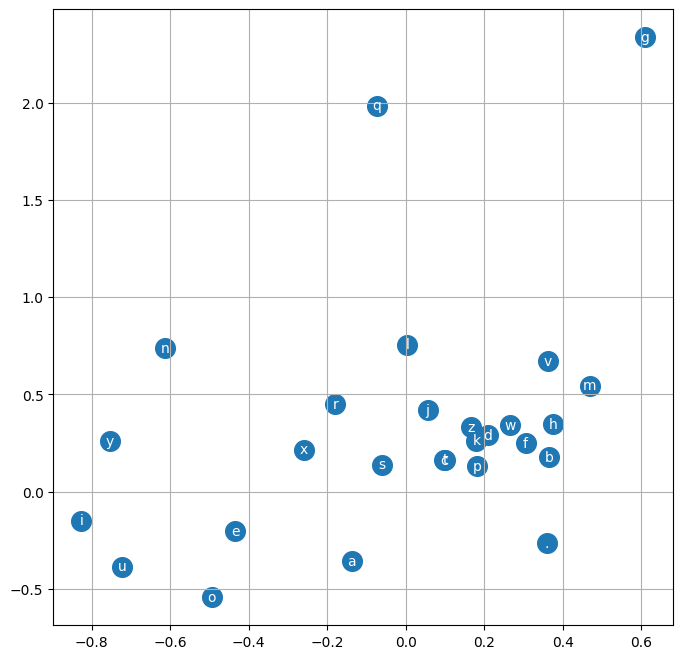

In [128]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va='center', color='white')
plt.grid('minor')

In [155]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carmah.
amille.
khi.
mili.
taty.
skanden.
jazheen.
delynn.
jareei.
nellara.
chaiir.
kaleigh.
ham.
pori.
quint.
suline.
liveni.
walee.
giearixi.
jaceenitsa.
